In [1]:
using Plots, LinearAlgebra

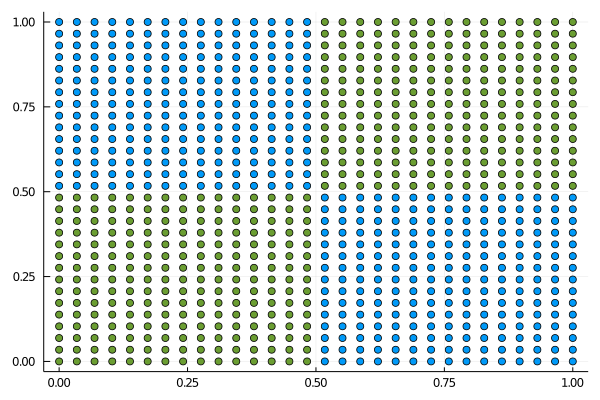

In [45]:
domain = range(0, stop=1, length=30)
dataset = vec([([x1, x2], round(Int64, x1) ⊻ round(Int64, x2)) for x1 in domain, x2 in domain])
scatter(map(x->x[1][1], dataset), map(x->x[1][2], dataset), color=map(x -> x[2][1], dataset), legend=false)

---

# "Almost" Zero-Allocation Neural Network

- https://stackoverflow.com/questions/38235555/tensorflow-matmul-of-input-matrix-with-batch-data
- https://www.google.com/search?q=batch+matrix+multiplication%5C&oq=batch+matrix+multiplication%5C&aqs=chrome..69i57j0i457j0l5j69i60.2539j0j7&sourceid=chrome&ie=UTF-8
- https://discourse.julialang.org/t/multiply-many-matrices-by-many-vectors/18542
- https://stackoverflow.com/questions/43801699/julia-multiply-each-matrix-along-dim

In [51]:
module ZeroAllocationNN

export ZANN
mutable struct ZANN
    weights :: Vector{Matrix{Float64}}
    biases :: Vector{Vector{Float64}}
    
    weighted_inputs :: Vector{Matrix{Float64}}
    activations :: Vector{Matrix{Float64}}
        
    nabla_ws :: Vector{Array{Float64,3}}
    nabla_bs :: Vector{Matrix{Float64}}
    
    function ZANN(layer_dims)
        weights = []
        biases = []
        for i = 2:length(layer_dims)
            push!(weights, randn(layer_dims[i], layer_dims[i - 1]))
            push!(biases, randn(layer_dims[i]))
        end
        return new(
            weights,
            biases,
            Vector{Vector{Float64}}(undef, length(layer_dims) - 1),
            Vector{Vector{Float64}}(undef, length(layer_dims)),
            Vector{Matrix{Float64}}(undef, length(layer_dims) - 1),
            Vector{Vector{Float64}}(undef, length(layer_dims) - 1)
        )
    end
end

sigma(x) = 1 / (1 + exp(-x))
sigma_prime(x) = sigma(x)*(1-sigma(x))

export predict
function predict(nn::ZANN, x :: Matrix{Float64})
    a = x
    for (w, b) in zip(nn.weights, nn.biases)
        a = sigma.(w * a .+ b) # .+ to repeat b along axis 1 (the minibatch size axis)
    end
    return a
end

function nabla_ws_from_delta_activations(nabla_ws, delta, a)
    size(delta, 2) == size(a, 2) || throw(DimensionMismatch("size(A, 2) must equal size(B, 2), found $(size(delta, 2)) and $(size(nn.activations[end-1], 2)) instead"))
    
    for i in 1:size(delta, 2)
        nabla_ws[:,:,i] = delta[:,i] * a[:,i]'
    end
end

export backprop
function backprop(nn::ZANN, x :: Matrix{Float64}, y :: Matrix{Float64})
    # forward pass, the difference from predict is that we save the activations
    # and the weighted inputs
    nn.activations[1] = x
    
    for (i, (w, b)) in enumerate(zip(nn.weights, nn.biases))
        nn.weighted_inputs[i] = w * nn.activations[i]
        @. nn.weighted_inputs[i] += b
        nn.activations[i+1] = sigma.(nn.weighted_inputs[i])
    end
    
    # backward pass
    # BP1 (Output layer error)
    delta :: Matrix{Float64} = (nn.activations[end] - y) .* sigma_prime.(nn.weighted_inputs[end])

    # BP3 (Cost gradient w.r.t Bias)
    nn.nabla_bs[1] = delta
    
    # BP4 (Cost gradient w.r.t weights)
    nn.nabla_ws[1] = Array{Float64, 3}(undef, size(delta, 1), size(nn.activations[end-1], 1), size(delta, 2))
    nabla_ws_from_delta_activations(nn.nabla_ws[1], delta, nn.activations[end-1])
    
    for (i, (w, z, a)) in enumerate(Iterators.reverse(zip(
                    nn.weights, nn.weighted_inputs[1:end-1], nn.activations[1:end-2])))
        # BP2 (Previous layer error)
        delta = (w'*delta)
        @. delta *= sigma_prime(z)
        
        nn.nabla_bs[i+1] = delta
        
        nn.nabla_ws[i+1] = Array{Float64, 3}(undef, size(delta, 1), size(a, 1), size(delta, 2))
        nabla_ws_from_delta_activations(nn.nabla_ws[i+1], delta, a)
    end
    
    return reverse(nn.nabla_ws), reverse(nn.nabla_bs)
end
end

import Main.ZeroAllocationNN

prepared_dataset_x = hcat(map(x->x[1], dataset)...)
prepared_dataset_y = hcat(map(x->float(x[2]), dataset)...)

println("Network creation ")
@time zann = ZeroAllocationNN.ZANN([2,4,2,1]);

println("Prediction ")
@time ZeroAllocationNN.predict(zann, prepared_dataset_x)

println("Backpropagation ")
ZeroAllocationNN.backprop(zann, prepared_dataset_x, prepared_dataset_y);
@time ZeroAllocationNN.backprop(zann, prepared_dataset_x, prepared_dataset_y);

Network creation 
  0.000022 seconds (22 allocations: 2.188 KiB)
Prediction 


  0.000131 seconds (8 allocations: 99.156 KiB)
Backpropagation 
  0.000748 seconds (8.12 k allocations: 1.128 MiB)


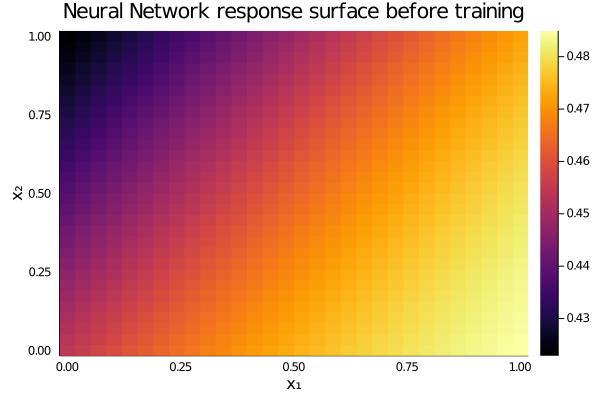

In [52]:
heatmap(
    domain,
    domain,
    (x1, x2) -> ZeroAllocationNN.predict(zann, reshape([x1; x2], 2, :))[1],
    title="Neural Network response surface before training",
    xlabel="x₁",
    ylabel="x₂"
)

---
## STOCHASTIC GRADIENT DESCENT (minibatch_size = 16)

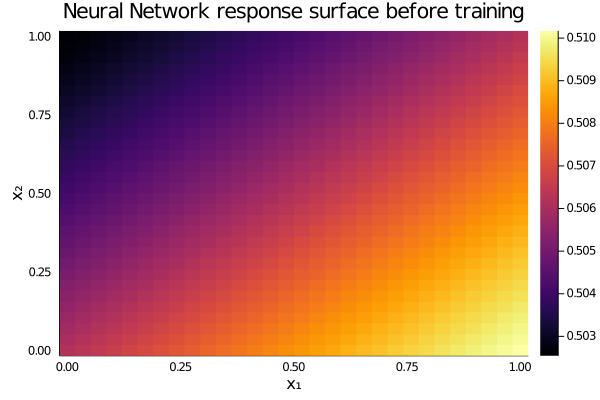

  3.531044 seconds (14.15 M allocations: 1.267 GiB, 6.18% gc time)
  

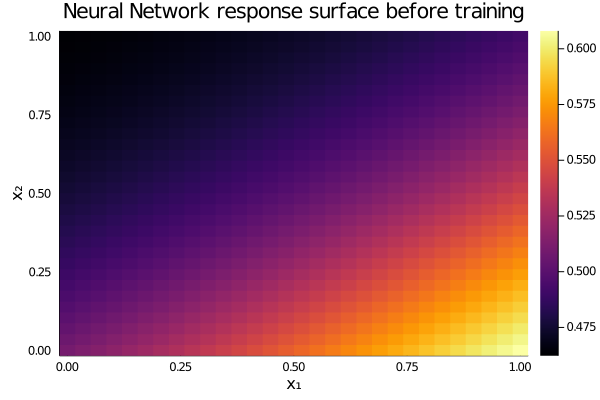

3.172689 seconds (13.95 M allocations: 1.257 GiB, 6.48% gc time)


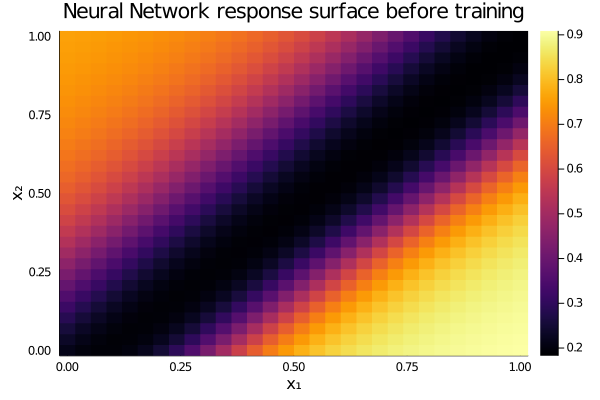

  3.130792 seconds (13.95 M allocations: 1.257 GiB, 6.06% gc time)
  

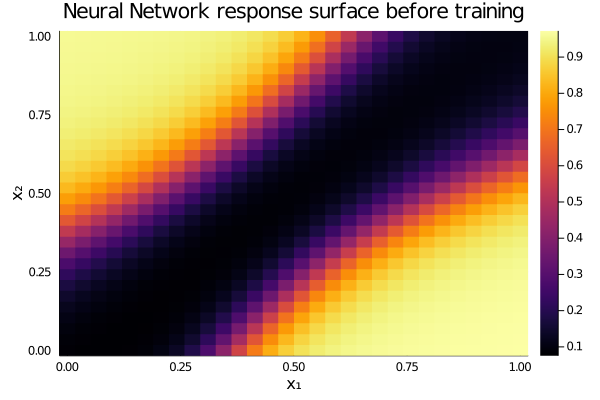

3.115167 seconds (13.95 M allocations: 1.257 GiB, 6.27% gc time)


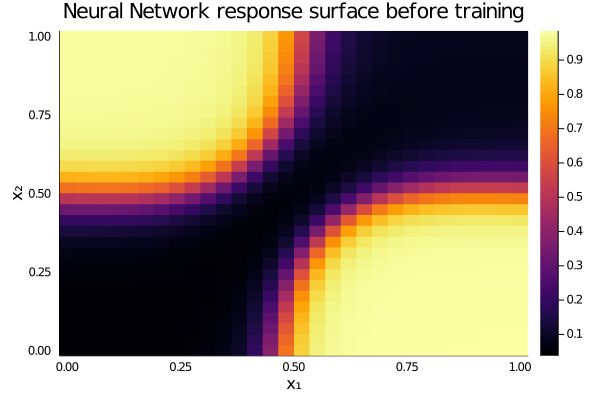

  3.247393 seconds (13.95 M allocations: 1.257 GiB, 6.20% gc time)
  

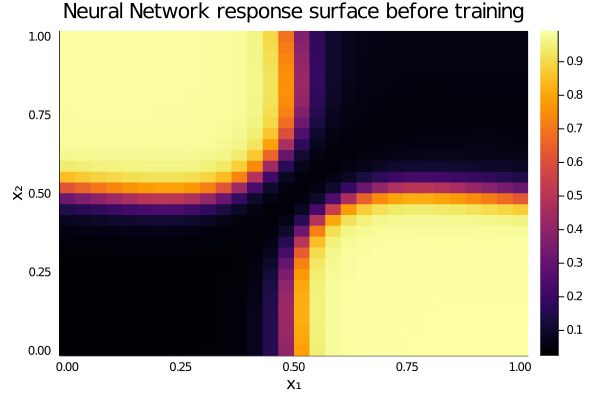

3.197265 seconds (13.95 M allocations: 1.257 GiB, 6.18% gc time)


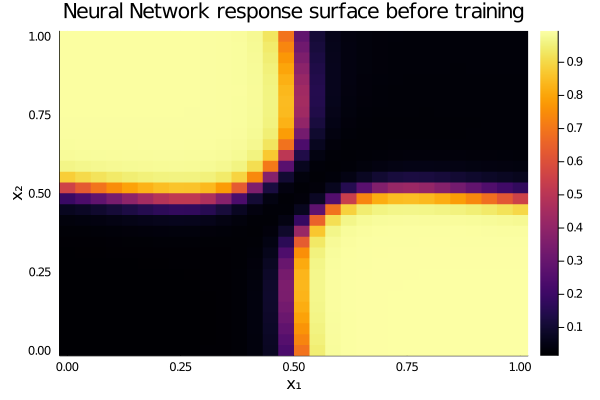

  3.308259 seconds (13.95 M allocations: 1.257 GiB, 5.98% gc time)
  

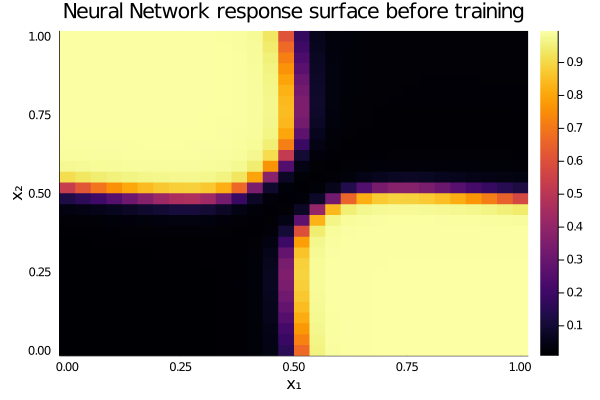

3.254998 seconds (13.95 M allocations: 1.257 GiB, 5.99% gc time)


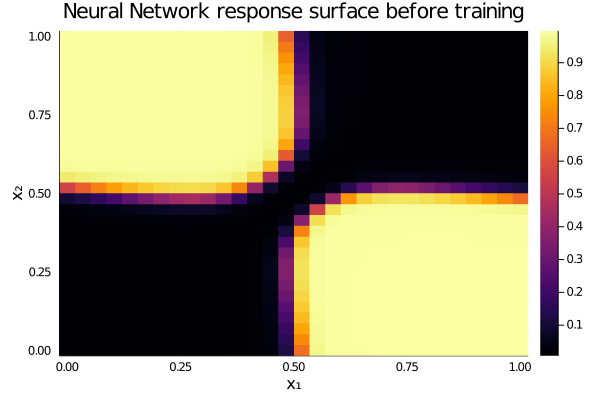

  3.415446 seconds (13.95 M allocations: 1.257 GiB, 5.89% gc time)
  

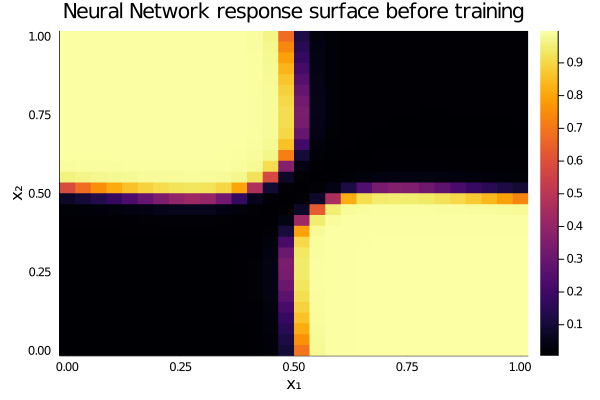

3.275429 seconds (13.95 M allocations: 1.257 GiB, 5.98% gc time)


In [57]:
epochs = 60_000
minibatch_size = 10
eta = 0.05

accuracy = Vector{Float64}()

for _ in 1:10
    @time for epoch in 1:epochs 
        # Obtain minibatch
        minibatch = rand(dataset, minibatch_size)
        x = hcat(map(x->x[1], minibatch)...)
        y = hcat(map(x->float(x[2]), minibatch)...)
        
        # Obtain gradient vectors with backpropagation
        delta_nabla_ws, delta_nabla_bs = ZeroAllocationNN.backprop(zann, x, y)

        # Average the gradients of each datum in the minibatch
        nabla_ws = map(x->x[:,:,1], sum.(delta_nabla_ws, dims=3)) / minibatch_size
        nabla_bs = map(x->x[:,1], sum.(delta_nabla_bs, dims=2)) / minibatch_size

        # Perform gradient descent using the gradients
        zann.weights -= (eta * nabla_ws)
        zann.biases -= (eta * nabla_bs)
        
        # Calculate accuracy
        if epoch % 1000 == 0
            predictions = ZeroAllocationNN.predict(zann, prepared_dataset_x)
            push!(accuracy, sum((prepared_dataset_y - predictions).^2)/length(dataset))
        end
    end

    display(heatmap(
        domain,
        domain,
        (x1, x2) -> ZeroAllocationNN.predict(zann, reshape([x1; x2], 2, :))[1],
        title="Neural Network response surface before training",
        xlabel="x₁",
        ylabel="x₂",
    ))
end

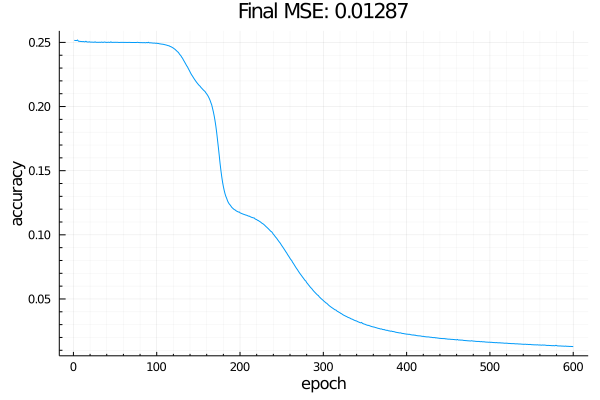

In [74]:
plot(accuracy, xlabel="epoch", ylabel="accuracy", minorgrid=true, minorticks=5, title="Final MSE: $(round(accuracy[end], digits=5))", label=false)

---
## ONLINE GRADIENT DESCENT (minibatch_size = 1)

In [6]:
# TODO(Andrea):  this should be more like:
#     14.545116 seconds (41.79 M allocations: 18.513 GiB, 16.75% gc time)

 28.445869 seconds (113.99 M allocations: 7.070 GiB, 3.91% gc time)


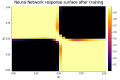

In [7]:
epochs = 1_000
eta = 0.05
@time for epoch in 1:epochs
    for (x, y) in dataset
        delta_nabla_ws, delta_nabla_bs = ZeroAllocationNN.backprop(zann, reshape(x, :, 1), reshape([float(y)], :, 1))

        nabla_ws = map(x->x[:,:,1], sum.(delta_nabla_ws, dims=3))
        nabla_bs = map(x->x[:,1], sum.(delta_nabla_bs, dims=2))

        zann.weights -= eta * nabla_ws
        zann.biases -= eta * nabla_bs
    end
end
heatmap(
    domain,
    domain,
    (x1, x2) -> ZeroAllocationNN.predict(zann, reshape([x1; x2], 2, :))[1],
    title="Neural Network response surface after training",
    xlabel="x₁",
    ylabel="x₂",
)

---

## MNIST

In [89]:
using MLDatasets

In [78]:
X_train, y_train = MNIST.traindata()

(FixedPointNumbers.Normed{UInt8,8}[0.0N0f8 0.0N0f8 … 0.0N0f8 0.0N0f8; 0.0N0f8 0.0N0f8 … 0.0N0f8 0.0N0f8; … ; 0.0N0f8 0.0N0f8 … 0.0N0f8 0.0N0f8; 0.0N0f8 0.0N0f8 … 0.0N0f8 0.0N0f8]

FixedPointNumbers.Normed{UInt8,8}[0.0N0f8 0.0N0f8 … 0.0N0f8 0.0N0f8; 0.0N0f8 0.0N0f8 … 0.0N0f8 0.0N0f8; … ; 0.0N0f8 0.0N0f8 … 0.0N0f8 0.0N0f8; 0.0N0f8 0.0N0f8 … 0.0N0f8 0.0N0f8]

FixedPointNumbers.Normed{UInt8,8}[0.0N0f8 0.0N0f8 … 0.0N0f8 0.0N0f8; 0.0N0f8 0.0N0f8 … 0.0N0f8 0.0N0f8; … ; 0.0N0f8 0.0N0f8 … 0.0N0f8 0.0N0f8; 0.0N0f8 0.0N0f8 … 0.0N0f8 0.0N0f8]

...

FixedPointNumbers.Normed{UInt8,8}[0.0N0f8 0.0N0f8 … 0.0N0f8 0.0N0f8; 0.0N0f8 0.0N0f8 … 0.0N0f8 0.0N0f8; … ; 0.0N0f8 0.0N0f8 … 0.0N0f8 0.0N0f8; 0.0N0f8 0.0N0f8 … 0.0N0f8 0.0N0f8]

FixedPointNumbers.Normed{UInt8,8}[0.0N0f8 0.0N0f8 … 0.0N0f8 0.0N0f8; 0.0N0f8 0.0N0f8 … 0.0N0f8 0.0N0f8; … ; 0.0N0f8 0.0N0f8 … 0.0N0f8 0.0N0f8; 0.0N0f8 0.0N0f8 … 0.0N0f8 0.0N0f8]

FixedPointNumbers.Normed{UInt8,8}[0.0N0f8 0.0N0f8 … 0.0N0f8 0.0N0f8; 0.0N0f8 0.0N0f8 … 0.0N0f8 0.0N

In [98]:
Float64.(reshape(X_train[:,:,1:3], 784, :))

784×3 Array{Float64,2}:
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 ⋮         
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0

In [102]:
println("Network creation ")
@time zann = ZeroAllocationNN.ZANN([784,100,20,1]);

println("Prediction ")
@time ZeroAllocationNN.predict(zann, Float64.(reshape(X_train[:,:,1:3], 784, :)))

# println("Backpropagation ")
# ZeroAllocationNN.backprop(zann, prepared_dataset_x, prepared_dataset_y);
# @time ZeroAllocationNN.backprop(zann, prepared_dataset_x, prepared_dataset_y);

Network creation 
  0.000501 seconds (23 allocations: 631.281 KiB)
Prediction 
  0.000235 seconds (18 allocations: 27.547 KiB)
